In [388]:
# 價格預測版本v4, 加入LSTM many to one

In [389]:
import pandas as pd
import urllib.request
import os
import datetime
import numpy as np
import time
import csv

from sklearn.metrics import mean_squared_error, r2_score
from google.colab import drive

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [390]:
# 選擇農產品，目前只有1 高麗菜, 15 香蕉
crop_no = 1
# 選擇市場，目前只有1
market_no = 1
# 是否要加入天氣資料
add_weather_data = True
# 是否要加入颱風資料
add_typhoon_data = False
# 訂定訓練資料的期間、測試資料的期間
train_start_date = '2000-01-01' # '2000-06-01'
train_end_date = '2020-05-31'
test_start_date = '2020-06-01'
test_end_date = '2021-06-30'
# 設定往前以及往後看的天數, 若many to many, past_day, future_day要設定一樣的值
past_day = 15
future_day = 15
# 畫多少天的預測圖，要小於或等於上面future_day的數字, one to one 只有1張
plot_day = 15
# 使用哪一個模型，目前有1, 2, 4
model_no = 1
# 其它參數
batch_size = 128
epochs = 1000
validation_split = 0.1
# 記錄現在時間
datetime_now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=+8))).strftime("%Y-%m-%dT%H:%M:%S")
# 是否要存入google drive
save_google = True
save_google_dir = '/content/drive/MyDrive/project/result/'
# Avg_price是否要shift
is_price_shift = None

In [391]:
if save_google: drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [392]:
# 農作物
crop_dict = {
    1 : ['cabbage', '高麗菜 (LA1 甘藍 初秋)'],
    2 : ['carrot', '胡蘿蔔 (SB2 胡蘿蔔 清洗)'],
    3 : ['beeftomato', '牛番茄 (FJ3 番茄 牛蕃茄)'],
    4 : ['cucumber', '胡瓜 (FD1 花胡瓜)'],
    5 : ['loofah', '絲瓜 (FF1 絲瓜)'],
    6 : ['cabbage2', '包心白菜 (LC1 包心白 包白)'],
    7 : ['shallots', '青蔥 (SE6 青蔥 粉蔥)'],
    8 : ['bittergourd', '苦瓜 (FG1 苦瓜 白大米)'],
    9 : ['onion', '洋蔥 (SD1 洋蔥 本產)'],
    10 : ['waterspinach', '空心菜 (LF2 蕹菜 小葉)'],

    11 : ['guava', '番石榴 (P1 番石榴 珍珠芭)'],
    12 : ['pineapple', '鳳梨 (B2 鳳梨 金鑽鳳梨)'],
    13 : ['papaya', '木瓜 (I1 木瓜 網室紅肉)'],
    14 : ['watermelon', '西瓜 (T1 西瓜 大西瓜)'],
    15 : ['banana', '香蕉 (A1 香蕉)'],
    16 : ['apple', '蘋果 (X69 蘋果 富士進口)'],
    17 : ['pear', '梨子 (O4 梨 新興梨)'],
    18 : ['grape', '葡萄 (S1 葡萄 巨峰)'],
    19 : ['dragonfruit', '火龍果 (812 火龍果 紅肉)'],
    20 : ['mango', '芒果 (R1 芒果 愛文)']
}

In [393]:
market_dict = {
    1 : '台北一'
}

In [394]:
1# 檔案下載url
weather_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/reportdaily_mean_fillna.csv'
typhoon_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/TyphoonDatabase.csv'
cabbage_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/Cabbage.csv'
banana_data_url = 'https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/Banana.csv'

In [395]:
# 將檔案下載至colab
if not os.path.exists('weather.csv'): urllib.request.urlretrieve(weather_data_url, 'weather.csv') 
if not os.path.exists('typhoon.csv'): urllib.request.urlretrieve(typhoon_data_url, 'typhoon.csv') 
if not os.path.exists('cabbage.csv'): urllib.request.urlretrieve(cabbage_data_url, 'cabbage.csv') 
if not os.path.exists('banana.csv'): urllib.request.urlretrieve(banana_data_url, 'banana.csv')

In [396]:
# 所有城市對照英文代碼
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

In [397]:
# 要移除的欄位列表
# weather columb全部列表: 'date', 'city', 'StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin', 'StnPresMinTime', 'Temperature', 'TMax', 'TMaxTime', 'TMin', 'TMinTime', 'TdDewPoint', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD', 'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10', 'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine', 'SunShineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVIMax', 'UVIMaxTime', 'CloudAmount'
weather_drop_columns = [
                        'StnPresMaxTime', 
                        'StnPresMinTime', 
                        'TMaxTime', 
                        'TMinTime', 
                        'RHMinTime', 
                        'WGustTime', 
                        'PrecpMax10', 
                        'PrecpMax10Time', 
                        'PrecpMax60', 
                        'PrecpMax60Time', 
                        'UVIMax', 
                        'UVIMaxTime'
]

In [398]:
# 讀取天氣資料
df = pd.read_csv('weather.csv', encoding='utf-8')
# 移除不需要的欄位
df = df.drop(weather_drop_columns, axis=1)
df.head(3)

,date,city,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,TMax,TMin,TdDewPoint,RH,RHMin,WS,WD,WSGust,WDGust,Precp,PrecpHour,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,CloudAmount
0,2000-01-01,南投縣,773.0,1527.9,775.0,771.4,9.0,14.3,6.5,1.1,60.0,37.5,7.5,301.0,14.1,262.5,0.0,0.0,9.8,91.5,12.0,34.4,2.8,1.4
1,2000-01-01,嘉義市,1013.0,1016.3,1015.5,1010.1,18.9,26.0,13.4,14.3,77.0,41.0,2.0,20.0,8.4,30.0,0.0,0.0,7.6,71.2,9.4,4.6,2.8,1.8
2,2000-01-01,嘉義縣,874.2,3156.4,767.6,764.6,14.0,14.9,3.7,-3.6,44.0,18.0,1.8,300.0,6.3,90.0,0.0,0.0,9.2,96.5,18.4,44.2,2.1,0.5


In [399]:
# 使用index做merge，將weather表格依日期拉平
df_date = df['date'].drop_duplicates().to_frame().set_index('date')

for cityname, citycode in city.items():
    df_city = df.loc[df['city'] == cityname].add_suffix('_' + citycode).set_index('date' + '_' + citycode)
    df_date = pd.merge(df_date, df_city, how='left', left_index = True, right_index = True)

df_date = df_date[df_date.columns.drop(list(df_date.filter(regex='city')))]
df_weather = df_date

df_weather.head(3)

,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMin_KLU,Temperature_KLU,TMax_KLU,TMin_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,Precp_KLU,PrecpHour_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,CloudAmount_KLU,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMin_TPE,Temperature_TPE,TMax_TPE,TMin_TPE,TdDewPoint_TPE,RH_TPE,RHMin_TPE,WS_TPE,WD_TPE,WSGust_TPE,WDGust_TPE,Precp_TPE,PrecpHour_TPE,SunShine_TPE,SunShineRate_TPE,...,Temperature_HWA,TMax_HWA,TMin_HWA,TdDewPoint_HWA,RH_HWA,RHMin_HWA,WS_HWA,WD_HWA,WSGust_HWA,WDGust_HWA,Precp_HWA,PrecpHour_HWA,SunShine_HWA,SunShineRate_HWA,GloblRad_HWA,VisbMean_HWA,EvapA_HWA,CloudAmount_HWA,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMin_TTT,Temperature_TTT,TMax_TTT,TMin_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,Precp_TTT,PrecpHour_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,CloudAmount_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1009.2,1016.9,1011.0,1007.2,19.3,22.6,16.9,14.3,73.5,63.0,3.8,280.0,10.6,180.0,2.2,0.4,3.8,36.6,5.6,13.9,2.0,6.0,996.4,1184.6,998.6,994.4,17.5,21.1,14.3,11.9,78.7,51.0,1.2,230.9,7.2,197.3,0.0,0.0,2.7,25.9,...,18.5,24.9,13.5,16.4,74.0,58.0,0.8,221.7,4.5,162.7,0.5,0.0,4.1,37.0,7.9,12.8,1.2,7.4,956.6,1015.0,989.5,982.9,19.2,25.0,17.7,16.9,74.8,61.8,1.8,119.2,7.2,75.2,0.0,0.0,3.1,28.9,7.6,15.5,2.9,7.1
2000-01-02,1010.9,1018.6,1012.6,1008.8,18.6,21.7,15.2,11.4,64.5,54.5,4.7,130.0,11.7,85.0,0.0,0.0,8.5,79.8,8.0,9.3,2.6,3.8,997.6,1187.6,999.4,995.2,16.8,22.6,12.1,9.0,68.7,43.3,1.9,98.3,10.0,93.7,0.0,0.0,7.6,71.9,...,17.9,23.0,14.6,13.7,62.0,42.0,1.1,215.7,6.7,139.9,0.3,0.0,2.6,23.0,7.2,13.0,1.5,9.0,957.0,1015.9,976.0,971.3,17.9,22.1,16.5,14.1,64.0,50.2,2.8,119.8,11.4,89.7,0.0,0.0,4.2,38.9,8.5,14.6,3.6,6.9
2000-01-03,1011.0,1018.6,1012.9,1009.2,18.7,20.8,16.3,10.0,58.0,48.0,3.9,60.0,10.3,85.0,0.0,0.0,5.0,47.4,7.0,8.8,3.0,5.1,997.1,1185.5,999.0,995.4,17.6,20.8,15.3,10.7,76.7,62.3,2.3,79.2,10.3,89.0,0.0,0.0,4.6,43.2,...,16.7,22.1,12.9,13.5,67.0,56.0,0.8,210.9,4.8,172.4,0.1,0.0,1.8,16.7,5.0,10.3,2.5,8.5,958.2,1016.9,989.8,986.6,16.9,22.2,16.2,13.5,64.2,56.5,2.2,101.1,9.8,66.7,0.0,0.0,5.2,47.8,8.0,13.1,3.2,6.5


In [400]:
# 計算兩個日期間隔多少天
def daysBetweenDate(startdate: str, enddate: str) -> int:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    enddate = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    days = (enddate - startdate).days + 1
    return days

# 日期調整
def dateShift(startdate: str, shiftday: int) -> str:
    startdate = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    targetdate = startdate + datetime.timedelta(days=shiftday)
    return datetime.datetime.strftime(targetdate, "%Y-%m-%d")

# 讀取颱風資料庫
df_typhoon = pd.read_csv('typhoon.csv', encoding='utf-8')

# 將Warning的日期文字轉為4個欄位'startdate','starttime','enddate','endtime'
df_typhoon[['startdate','starttime','enddate','endtime']] = df_typhoon['Warning'].str.split().tolist()
# 將最前面塞入date欄位
df_typhoon_new = pd.DataFrame(columns=df_typhoon.columns.insert(0, 'date'))

# 將所有颱風按日期列出
# 使用iterrows
start_time = time.time()
for index, row in df_typhoon.iterrows():
    days = daysBetweenDate(row['startdate'], row['enddate'])
    for day in range(0, days):
        date = dateShift(row['startdate'],day)
        datesr1 = pd.Series(date).append(df_typhoon.iloc[index]).rename({0: 'date'})
        df_typhoon_new = df_typhoon_new.append(datesr1, ignore_index=True)

# 將相同日期的去除並暫時只留WarnMark欄位
df_typhoon_wm = pd.DataFrame(df_typhoon_new, columns=['date'])
df_typhoon_wm['WarnMark'] = 1
df_typhoon_wm = df_typhoon_wm.drop_duplicates().reset_index().drop(columns=['index'])

df_typhoon = df_typhoon_wm.set_index('date')

print(df_typhoon.head(3))


            WarnMark
date                
2021-06-03         1
2021-06-04         1
2020-11-05         1


In [401]:
# 要移除的欄位列表
# market columns 全部列表: 'Date', 'Market', 'Product', 'Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume', 'Month', 'Week_day', 'Year', 'Rest_day'
market_drop_columns = [
                       'Up_price', 
                       'Mid_price',
                       'Low_price'
]

In [402]:
# 讀取農產品資料
csv_name = crop_dict[crop_no][0] + '.csv'
df = pd.read_csv(csv_name, encoding='utf-8')
# 移除不需要的欄位
df = df.drop(market_drop_columns, axis=1)
df.head(3)

,Date,Market,Product,Avg_price,Volume,Month,Week_day,Year,Rest_day
0,2000-01-01,西螺鎮,LA1 甘藍 初秋,6.9,255395.0,1,6,2000,0
1,2000-01-02,西螺鎮,LA1 甘藍 初秋,7.2,247275.0,1,7,2000,0
2,2000-01-03,西螺鎮,LA1 甘藍 初秋,7.3,242391.0,1,1,2000,0


In [403]:
# 將休市價格填入前一日價格
df = df.fillna(method="ffill")
# 只拿出指定市場的資料
df = df[df.Market == market_dict[market_no]]

df = df.dropna()
df_crop = df.rename(columns={'Date': 'date'}).set_index('date')

print(df_crop.head(3))
print(df_crop.tail(3))

           Market     Product  Avg_price  ...  Week_day  Year  Rest_day
date                                      ...                          
2000-01-02    台北一  LA1 甘藍 初秋         8.9  ...         7  2000         0
2000-01-03    台北一  LA1 甘藍 初秋         7.2  ...         1  2000         0
2000-01-04    台北一  LA1 甘藍 初秋         6.7  ...         2  2000         0

[3 rows x 8 columns]
           Market     Product  Avg_price  ...  Week_day  Year  Rest_day
date                                      ...                          
2021-06-17    台北一  LA1 甘藍 初秋        15.1  ...         4  2021         0
2021-06-18    台北一  LA1 甘藍 初秋        15.1  ...         5  2021         0
2021-06-19    台北一  LA1 甘藍 初秋        15.5  ...         6  2021         0

[3 rows x 8 columns]


In [404]:
df_all = df_crop
# 是否要合併天氣資料
if add_weather_data:
  df_all = pd.merge(df_all, df_weather, how='inner', left_index = True, right_index = True)
# 是否要合併颱風資料
if add_typhoon_data:
  df_all = pd.merge(df_all, df_typhoon, how='left', left_index = True, right_index = True).fillna(0)

# 把平均價格移到最後1欄
col_Avg_price = df_all.pop('Avg_price')
df_all = pd.concat([df_all, col_Avg_price], 1)
print(df_all.head(3))
print(df_all.tail(3))

           Market     Product    Volume  ...  EvapA_TTT  CloudAmount_TTT  Avg_price
date                                     ...                                       
2000-01-02    台北一  LA1 甘藍 初秋   192029.0  ...        3.6              6.9        8.9
2000-01-03    台北一  LA1 甘藍 初秋   174270.0  ...        3.2              6.5        7.2
2000-01-04    台北一  LA1 甘藍 初秋   125426.0  ...        2.6              7.0        6.7

[3 rows x 426 columns]
           Market     Product    Volume  ...  EvapA_TTT  CloudAmount_TTT  Avg_price
date                                     ...                                       
2021-06-16    台北一  LA1 甘藍 初秋   128693.0  ...        7.4              4.4       21.0
2021-06-17    台北一  LA1 甘藍 初秋    96289.0  ...        7.2              2.5       15.1
2021-06-18    台北一  LA1 甘藍 初秋   148701.0  ...        6.9              2.4       15.1

[3 rows x 426 columns]


In [405]:
###############################以上基本資料處理結束###############################################

In [406]:
# 建立訓練資料，將資料整理為x_train, y_train
def buildTrain(train, past_day, future_day, is_price_shift):
  x_train, y_train = [], []
  # i+past_day = 本日
  if is_price_shift:
    for i in range(train.shape[0]-future_day-past_day):
      x_train.append(train[i:i+past_day])
      y_train.append(train[i+past_day+future_day-1, -1])
    return np.array(x_train), np.array(y_train)
  else:
    for i in range(train.shape[0]-future_day-past_day):
      x_train.append(train[i:i+past_day])
      y_train.append(train[i+past_day:i+past_day+future_day, -1])
    return np.array(x_train), np.array(y_train)

In [407]:
# 建立測試資料，將資料整理為x_test, y_test, y_real
def buildTest(test, past_day, future_day, is_price_shift):
  x_test, y_test, y_real = [], [], []
  # i+past_day = 本日  
  if is_price_shift:
    for i in range(test.shape[0]-future_day-past_day):
      x_test.append(test[i:i+past_day])
      y_test.append(test[i+past_day+future_day-1, -1])
      y_real.append(test[i+past_day+future_day-1][-1])
    return np.array(x_test), np.array(y_test), np.array(y_real)
  else:  
    for i in range(test.shape[0]-future_day-past_day):
      x_test.append(test[i:i+past_day])
      y_test.append(test[i+past_day:i+past_day+future_day, -1])
      y_real.append(test[i+past_day][-1])
    return np.array(x_test), np.array(y_test), np.array(y_real)

In [408]:
# 將資料切分為訓練資料及驗證資料
def splitData(X,Y,rate):
  X_train = X[:int(X.shape[0]*(1-rate))]
  Y_train = Y[:int(Y.shape[0]*(1-rate))]
  X_val = X[int(X.shape[0]*(1-rate)):]
  Y_val = Y[int(Y.shape[0]*(1-rate)):]

  return X_train, Y_train, X_val, Y_val

In [409]:
# 模型建立
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  # model.add(Lambda(lambda x: x[:, -7:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [410]:
# 模型2
def buildManyToManyModel2(shape):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(shape[1], shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [411]:
# 模型3
def buildManyToManyModel3(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # model.add(TimeDistributed(Dense(1)))
  # https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  model.add(Lambda(lambda x: x[:, past_day*-1:, :])) #Select last N from output
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [412]:
# 模型4
def buildManyToOneModel4(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [413]:
# 模型字典: function name, 說明, 是否shift day, 是否只輸出1天
model_dict = {
    1 : [buildManyToManyModel, 'LSTM many to many', False, False],
    2 : [buildManyToManyModel2, 'LSTM many to many', False, False],
    3 : [buildManyToManyModel3, 'LSTM many to many', False, False],
    4 : [buildManyToOneModel4, 'LSTM many to one', True, True],
    5 : ['', ''],
}

In [414]:
# 判斷是否要先將y_train, y_test的資料shift
is_price_shift = model_dict[model_no][2]

In [415]:
# 將資料複製一份來作業, 將欄位index改為date
df = df_all.copy()
df = df.reset_index().rename(columns={'index': 'date'})

# 依訓練資料的期間、測試資料的期間來切分資料
df_train = df.iloc[df[(train_start_date <= df.date) & (df.date <= train_end_date)].index].set_index('date')
df_test = df.iloc[df[(test_start_date <= df.date) & (df.date <= test_end_date)].index].set_index('date')

# 將非數字的欄位移除
df_train = df_train.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])

print(df_train.dtypes)

Volume             float64
Month                int64
Week_day             int64
Year                 int64
Rest_day             int64
                    ...   
GloblRad_TTT       float64
VisbMean_TTT       float64
EvapA_TTT          float64
CloudAmount_TTT    float64
Avg_price          float64
Length: 424, dtype: object


In [416]:
# 設定x_train, y_train的scaler
x_sc = MinMaxScaler()
y_sc = MinMaxScaler()

# 將訓練資料做MinMaxScaler
# 先將y_train fit MinMaxScaler，待未來使用
x_sc.fit(df_train)
y_train = df_train['Avg_price']
y_sc.fit(y_train.to_frame())

df_train_scaled = x_sc.transform(df_train)

# 製作x_train, y_train
x_train, y_train = buildTrain(df_train_scaled, past_day, future_day, is_price_shift)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (7426, 15, 424)
y_train shape: (7426, 15)


In [417]:
# 將資料切分為訓練資料及驗證資料
x_train, y_train, x_val, y_val = splitData(x_train, y_train, validation_split)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

# 將資料由2D改為3D
if is_price_shift:
  y_train = y_train[:,np.newaxis,np.newaxis]
  y_val = y_val[:,np.newaxis,np.newaxis]
else:  
  y_train = y_train[:,:,np.newaxis]
  y_val = y_val[:,:,np.newaxis]
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

x_train shape: (6683, 15, 424)
y_train shape: (6683, 15)
x_val shape: (743, 15, 424)
y_val shape: (743, 15)
y_train shape: (6683, 15, 1)
y_val shape: (743, 15, 1)


In [418]:
# 模型建立
try:
  model = model_dict[model_no][0](x_train.shape)
  print('model_no:', model_no)
except Exception as e:
	print('model選錯了, except:', e)
 
# 模型訓練
callback = EarlyStopping(monitor="loss", patience=10, verbose=2, mode="auto")
model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_val, y_val), callbacks=[callback])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 10)            17400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 1)             11        
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________
model_no: 1
Epoch 1/1000
53/53 [==============================] - 2s 16ms/step - loss: 0.0646 - val_loss: 0.0210
Epoch 2/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 3/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 4/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0174
Epoch 5/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0174

In [419]:
# 儲存模型
if save_google: model.save(save_google_dir + (datetime_now) + '.h5')

In [420]:
# 將x_test做MinMaxScaler
df_test_scaled = x_sc.transform(df_test)
print(df_test_scaled.shape)

# 將資料切為x_test, y_test
x_test, y_test, y_real = buildTest(df_test_scaled, past_day, future_day, is_price_shift)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('y_real shape:', y_real.shape)

(383, 424)
x_test shape: (353, 15, 424)
y_test shape: (353, 15)
y_real shape: (353,)


In [421]:
# 執行價格預測
x_test_pred = model.predict(x_test)
print('x_test_pred.shape:', x_test_pred.shape)

x_test_pred_shape = x_test_pred.reshape(x_test_pred.shape[0], x_test_pred.shape[1])
print('x_test_pred_shape.shape', x_test_pred_shape.shape)
y_real_shape = y_real.reshape(y_real.shape[0], 1)
print('y_real.shape', y_real.shape)
# 將預測值轉換回實際價格
x_test_pred_price = y_sc.inverse_transform(x_test_pred_shape)
y_real_price = y_sc.inverse_transform(y_real_shape)

# 建立可視的價格預測表
# daycolumn_x = ['D' + str(x) for x in list(range(1, future_day+1))]
# daycolumn_y = ['D0']
# print('預測價格：\n', pd.DataFrame(x_test_pred_price[:,:future_day], columns=daycolumn_x))
# print('實際價格：\n', pd.DataFrame(y_real_price[:future_day], columns=daycolumn_y))

x_test_pred.shape: (353, 15, 1)
x_test_pred_shape.shape (353, 15)
y_real.shape (353,)


In [422]:
print('x_test.shape:', x_test_pred.shape)
print('y_test.shape:', y_test.shape)
score = model.evaluate(x_test, y_test, verbose = 0) 
score

x_test.shape: (353, 15, 1)
y_test.shape: (353, 15)


0.01624012552201748

In [423]:
# 畫圖
def drawResult(true_value, pred_value, plot_day):
  for i in range(plot_day):
    # i + 1 = 未來1日的價格
    Dday = i + 1
    real_price = true_value
    pred_price = pred_value[:,i:Dday]
    for j in range(Dday):
      pred_price = np.insert(pred_price, 0, None)
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    ax.plot(real_price, label='real price')
    ax.plot(pred_price, label='pred price')

    ax.set(xlabel='day', ylabel='price', title='predict D' + str(Dday) + ' price')
    ax.legend()
    ax.grid()

    if save_google: plt.savefig(save_google_dir + datetime_now + '_D' + str(Dday) + '.png')

    plt.show()

def drawResultOne(true_value, pred_value, plot_day=1):

  real_price = true_value
  pred_price = pred_value
  
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 5)

  ax.plot(real_price, label='real price')
  ax.plot(pred_price, label='pred price')

  ax.set(xlabel='day', ylabel='price', title='predict D' + str(future_day) + ' price')
  ax.legend()
  ax.grid()

  if save_google: plt.savefig(save_google_dir + datetime_now + '_D' + str(future_day) + '.png')

  plt.show()    

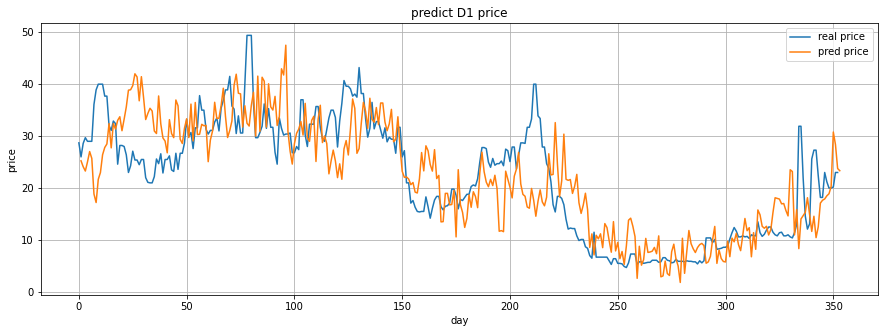

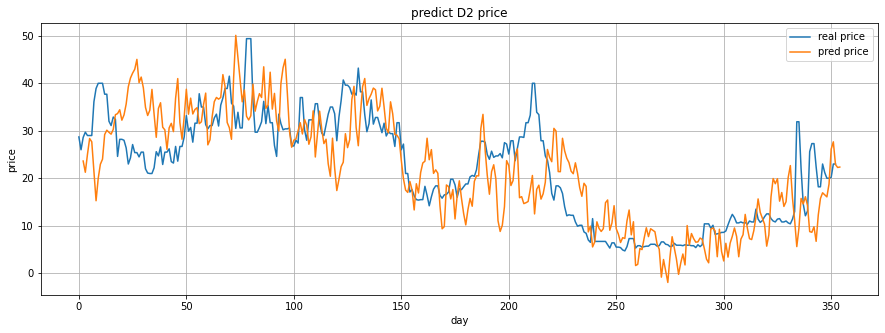

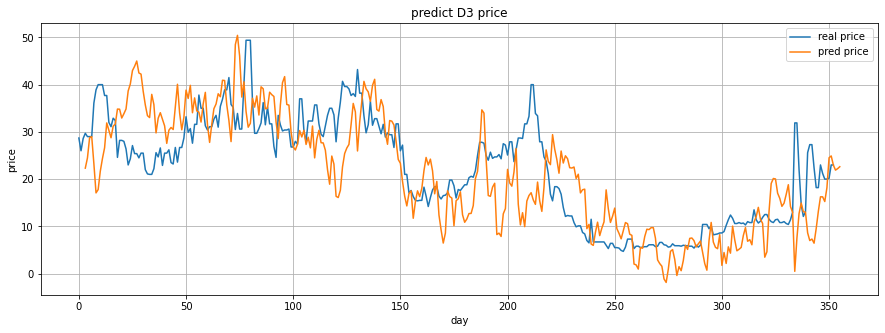

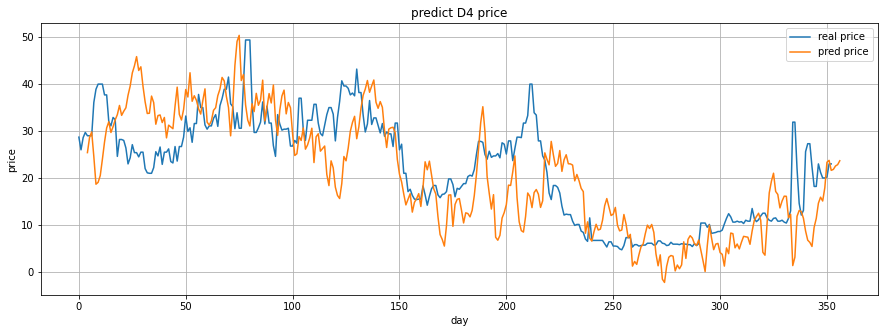

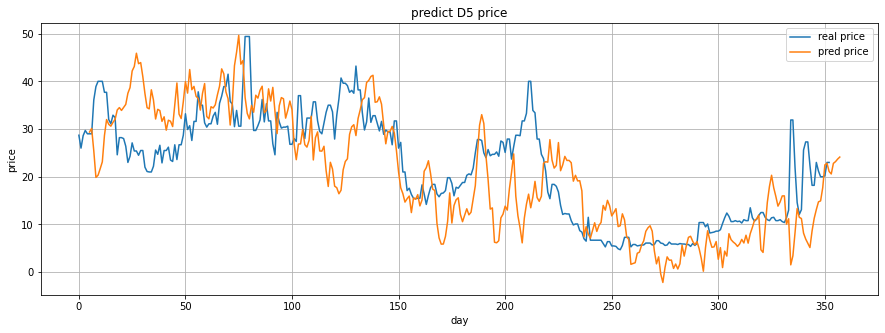

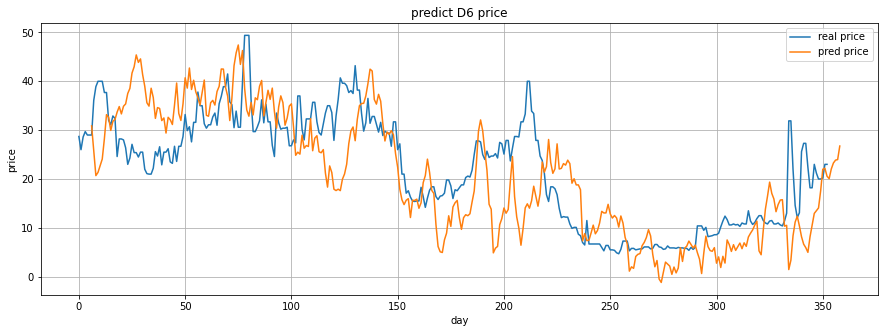

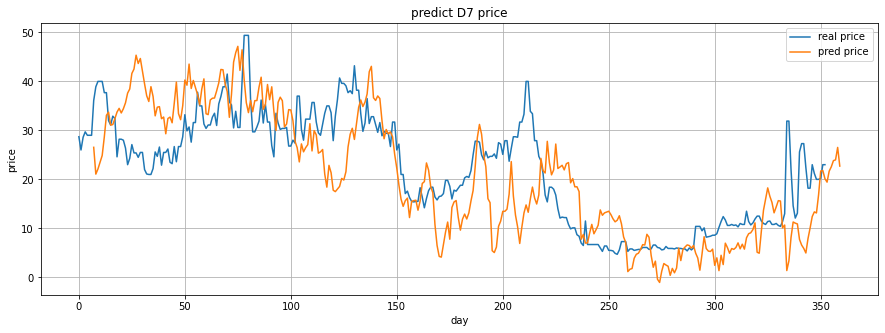

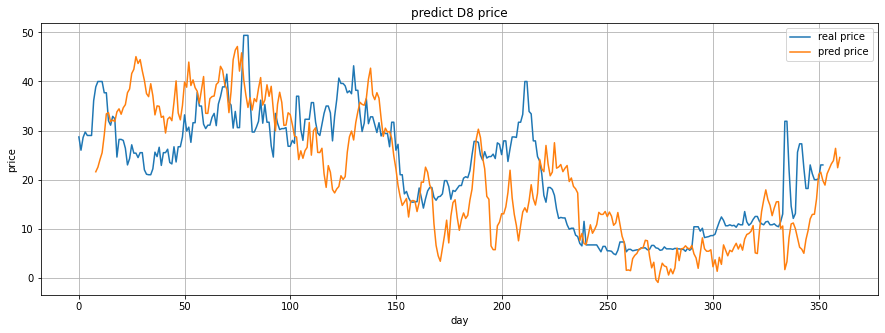

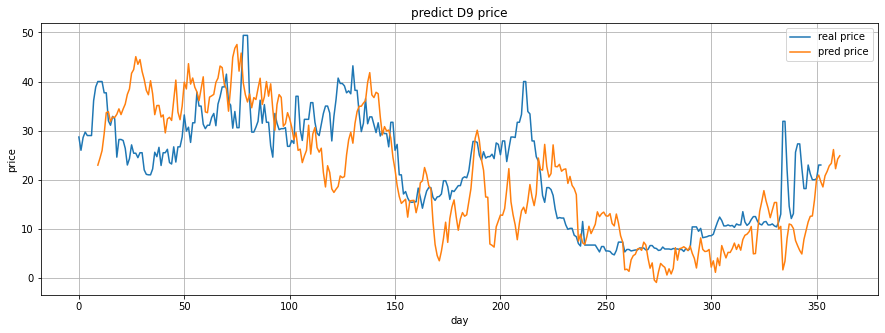

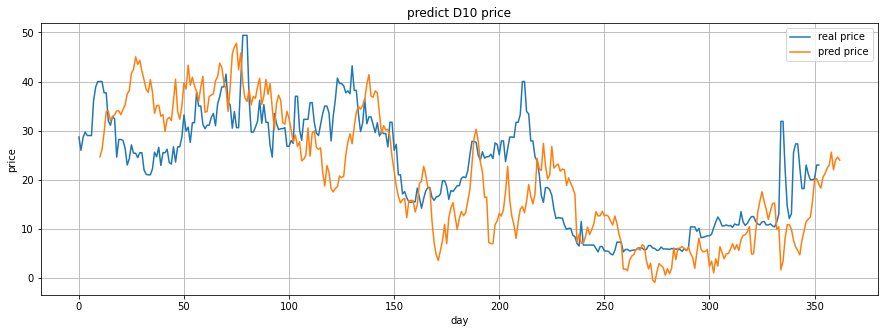

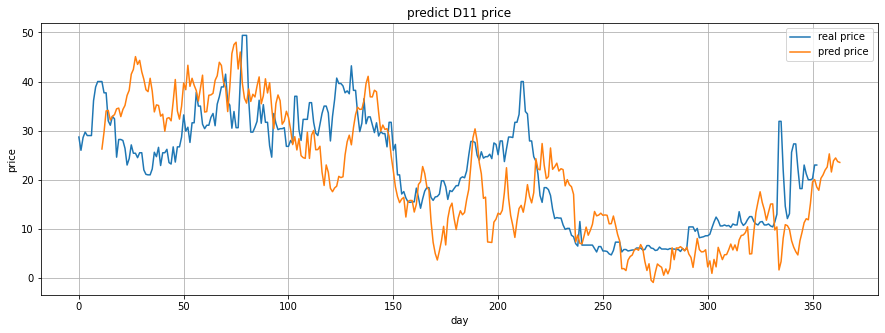

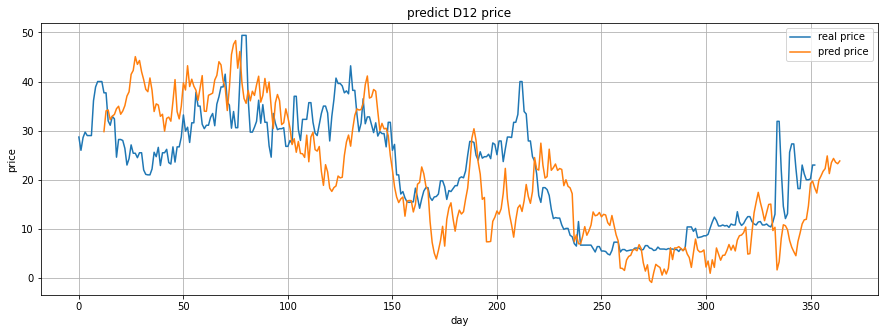

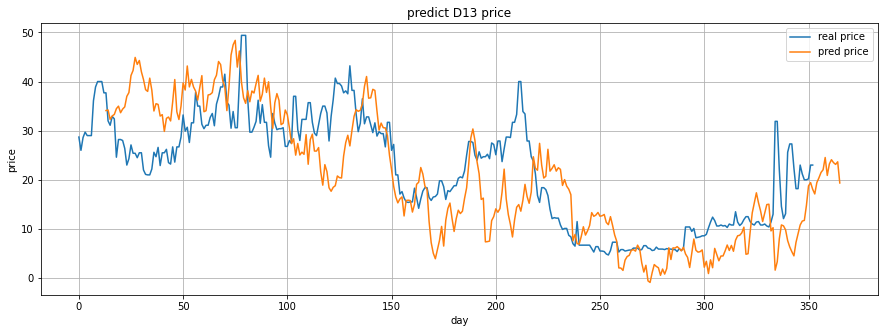

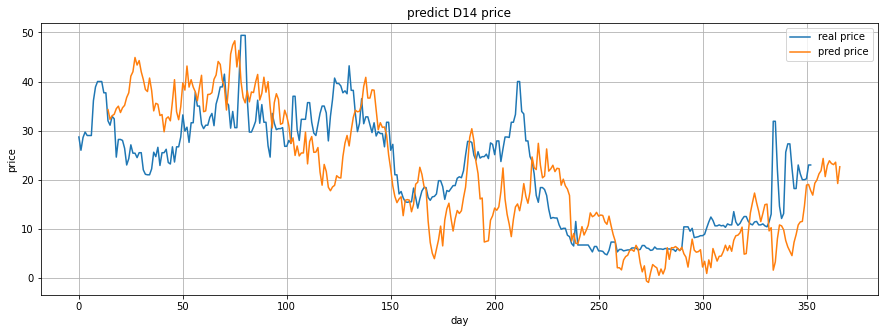

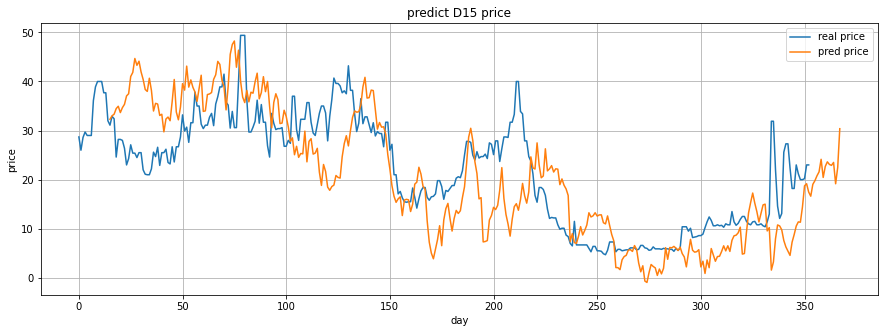

In [424]:
# 畫圖
pp = x_test_pred_price
rp = y_real_price

is_output_one = model_dict[model_no][3]
if is_output_one:
  drawResultOne(rp, pp)
else:
  drawResult(rp, pp, plot_day)

In [425]:
# 記錄結果
result_column_lists = ['datetime', 'crop_name', 'market_name', 'add_weather_data', 'add_typhoon_data', 'train_start_date', 'model_no', 'model_name', 'past_day', 'future_day', 'batch_size', 'epochs', 'validation_split', 'predDay', 'MSE', 'RMSE', 'R2']

def saveResult(path, preDay, real_value, pred_value):
  with open(path, 'a', newline='', encoding='utf-8') as f:
    result_writer = csv.writer(f)
    if f.tell()==0: result_writer.writerow(result_column_lists)
    for i in range(preDay):
      # i + 1 = 未來1日的價格
      Dday = i + 1
      real_price = real_value[Dday:]
      pred_price = pred_value[:-Dday,i]

      MSE = mean_squared_error(real_price, pred_price)
      RMSE = np.sqrt(MSE)
      R2 = r2_score(real_price, pred_price)
      
      result_lists = [datetime_now, crop_dict[crop_no][1], market_dict[market_no], add_weather_data, add_typhoon_data, train_start_date, model_no, model_dict[model_no][1], past_day, future_day, batch_size, epochs, validation_split, Dday, MSE, RMSE, R2]
      result_writer.writerow(result_lists)

def saveResultOne(path, preDay, real_value, pred_value):
  with open(path, 'a', newline='', encoding='utf-8') as f:
    result_writer = csv.writer(f)
    if f.tell()==0: result_writer.writerow(result_column_lists)
    real_price = real_value
    pred_price = pred_value

    MSE = mean_squared_error(real_price, pred_price)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(real_price, pred_price)
    
    result_lists = [datetime_now, crop_dict[crop_no][1], market_dict[market_no], add_weather_data, add_typhoon_data, train_start_date, model_no, model_dict[model_no][1], past_day, future_day, batch_size, epochs, validation_split, preDay, MSE, RMSE, R2]
    result_writer.writerow(result_lists)      

In [426]:
# 儲存結果
is_output_one = model_dict[model_no][3]
if is_output_one:
  saveResultOne('result.csv', future_day, rp, pp)
  if save_google: saveResultOne(save_google_dir + 'result.csv', future_day, rp, pp)
else:
  saveResult('result.csv', future_day, rp, pp)
  if save_google: saveResult(save_google_dir + 'result.csv', future_day, rp, pp)



In [427]:
# 把本次的結果顯示出來
pdresult = pd.read_csv('result.csv')
pdresult[pdresult.datetime == datetime_now]

,datetime,crop_name,market_name,add_weather_data,add_typhoon_data,train_start_date,model_no,model_name,past_day,future_day,batch_size,epochs,validation_split,predDay,MSE,RMSE,R2
254,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,1,54.844333,7.405696,0.539738
255,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,2,67.601386,8.222006,0.434074
256,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,3,75.820275,8.707484,0.366416
257,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,4,80.606968,8.978138,0.327380
258,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,5,83.359785,9.130158,0.305575
259,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,6,84.741230,9.205500,0.295250
260,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,7,85.296584,9.235615,0.291820
261,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,8,85.092497,9.224559,0.292116
262,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,9,84.492772,9.191995,0.294180
263,2021-07-25T01:29:56,高麗菜 (LA1 甘藍 初秋),台北一,True,False,2000-01-01,1,LSTM many to many,15,15,128,1000,0.1,10,84.129397,9.172208,0.293559


In [428]:
## code會在這兒停止
# class StopExecution(Exception):
#   def _render_traceback_(self):
#     pass

# raise StopExecution

In [429]:
###############################以下是參考###############################################

In [430]:
# https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
# The input to every LSTM layer must be three-dimensional.

# The three dimensions of this input are:

# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.